<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/Zman42/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6: Deep Learning with CNNs for Star Morphology Analysis

In this final assignment, you will use the same FITS files you explored previously, which contain astronomical images of stars in a specific region of the sky. This time, you will train a convolutional neural network (CNN) to classify stars based on morphological features directly from cropped image patches extracted from the FITS image.

The CNN will be used to:
- Distinguish between point sources (stars), extended sources (galaxies or nebula fragments), and image artifacts (like hot pixels or diffraction spikes).
- Optionally predict star brightness class (dim, moderate, bright) or other physically relevant labels.

### Learning Objectives:

By the end of this assignment, you should be able to:
- Understand how convolutional neural networks extract spatial features from astronomical images.
- Build and train a CNN using TensorFlow.
- Evaluate and visualize model performance on scientific image data.

In [1]:
# Install required libraries
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch astroquery pytest ipytest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00


In [2]:
import ipytest
ipytest.autoconfig()
import pytest

# For pytest to recognize a test function it should start with test

In [ ]:
def my_sum(a, b):
  return a + b

In [ ]:
%%ipytest
# This defines a unit test

def test_my_sum():
  """ This tests my function for arithematic correctness """
  assert my_sum(1, 2) == 3
  assert my_sum(0, 0) == 0
  assert my_sum(-1, 1) == 0

.                                                                                            [100%]
1 passed in 0.01s


In [ ]:
def test_my_sum_datatype():
  with pytest.raises(TypeError):
    my_sum("a", "b")

## Task 1: Data Preparation (8 points)
- Use the same FITS file from Homework 5
- Use astropy to determine the wcs coordinates of the image
- Generate a pandas list os the 10 brightest objects in the image

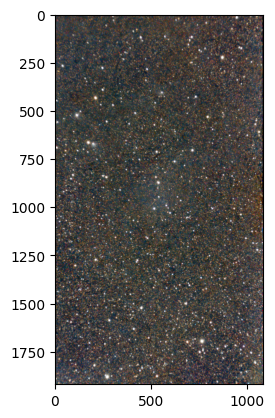

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

# Replace this URL with the raw URL of your FITS file on GitHub
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/9.fits"

# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))

In [4]:
import pandas as pd
from astropy.wcs import WCS
from astropy.stats import mad_std
import photutils.detection as detection


bkg_sigma = mad_std(np.mean(rgb_data, axis=2))

daofind = detection.DAOStarFinder(fwhm=3.0, threshold=10 * bkg_sigma, min_separation = 15)
grayscale_data = np.mean(rgb_data, axis=2)
sources = daofind(grayscale_data)

catalog = sources.to_pandas().sort_values(by = 'flux', ascending = False).head(10)

catalog


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
849,850,762.617670,1698.285320,0.393441,0.508725,0.280985,25,55592.666667,863933.333333,-14.841201,-6.306582
935,936,270.189192,1883.728999,0.467650,0.253469,0.292611,25,44927.666667,631321.333333,-14.500626,-6.174538
162,163,172.323143,665.960800,0.382743,0.672629,-0.054889,25,32595.333333,431033.333333,-14.086277,-6.042414
32,33,868.502864,224.172201,0.413062,0.097708,0.531266,25,24428.333333,366451.000000,-13.910040,-5.474822
284,285,536.656013,874.877922,0.428316,0.229937,-0.122278,25,31826.333333,354293.333333,-13.873407,-6.141146
82,83,209.456015,434.268718,0.414549,0.915600,0.281041,25,23477.000000,302093.333333,-13.700353,-5.729350
747,748,447.772022,1525.379333,0.464987,0.415208,0.208688,25,24964.666667,296273.666667,-13.679233,-5.760270
184,185,713.002122,706.316598,0.388444,0.341650,0.115665,25,25095.000000,286229.000000,-13.641784,-5.934751
101,102,112.769993,524.008081,0.476320,0.684132,-0.022722,25,12361.666667,157525.333333,-12.993376,-4.941257
261,262,265.723346,846.111656,0.500155,0.353885,-0.159704,25,14880.666667,151282.666667,-12.949473,-5.305962


In [5]:
wcs = WCS(hdul[0].header, naxis=2)
print(wcs)
sky_coords = wcs.all_pix2world(catalog['xcentroid'], catalog['ycentroid'], 1)
catalog['ra'] = sky_coords[0]
catalog['dec'] = sky_coords[1]
catalog

WCS Keywords

Number of WCS axes: 2
CTYPE : '' '' 
CRVAL : 97.6322976187 10.0041591631 
CRPIX : 677.491210938 819.672637939 
PC1_1 PC1_2  : -0.999872664649102 -0.0123852235907072 
PC2_1 PC2_2  : 0.015972408734258 -0.999923160613342 
CDELT : 0.00110882142837567 0.00110781403209076 
NAXIS : 1080  1920  3


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec
849,850,762.617670,1698.285320,0.393441,0.508725,0.280985,25,55592.666667,863933.333333,-14.841201,-6.306582,97.525854,9.032401
935,936,270.189192,1883.728999,0.467650,0.253469,0.292611,25,44927.666667,631321.333333,-14.500626,-6.174538,98.069253,8.818266
162,163,172.323143,665.960800,0.382743,0.672629,-0.054889,25,32595.333333,431033.333333,-14.086277,-6.042414,98.194478,10.165492
32,33,868.502864,224.172201,0.413062,0.097708,0.531266,25,24428.333333,366451.000000,-13.910040,-5.474822,97.428705,10.667192
284,285,536.656013,874.877922,0.428316,0.229937,-0.122278,25,31826.333333,354293.333333,-13.873407,-6.141146,97.787681,9.940515
82,83,209.456015,434.268718,0.414549,0.915600,0.281041,25,23477.000000,302093.333333,-13.700353,-5.729350,98.156492,10.422801
747,748,447.772022,1525.379333,0.464987,0.415208,0.208688,25,24964.666667,296273.666667,-13.679233,-5.760270,97.877291,9.218363
184,185,713.002122,706.316598,0.388444,0.341650,0.115665,25,25095.000000,286229.000000,-13.641784,-5.934751,97.594484,10.130355
101,102,112.769993,524.008081,0.476320,0.684132,-0.022722,25,12361.666667,157525.333333,-12.993376,-4.941257,98.262453,10.321683
261,262,265.723346,846.111656,0.500155,0.353885,-0.159704,25,14880.666667,151282.666667,-12.949473,-5.305962,98.088453,9.967586


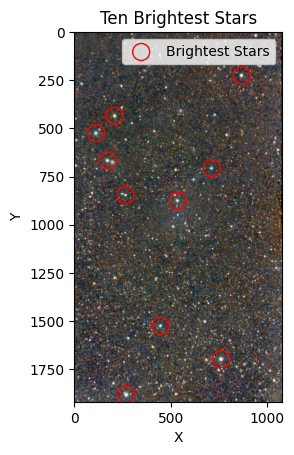

In [6]:
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))
plt.scatter(catalog['xcentroid'], catalog['ycentroid'], color='red', marker = 'o', facecolors='none', s=150, label='Brightest Stars')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Ten Brightest Stars')
plt.show()


## Task 2: Determine the properties of the stars based on a catalog (8 points)
- use the SIMBAD catalog (available through astropy) to determine the following properties of the 10 brightest objects in you image:
    - Name of the object
    - Spectral class
    - object type
    - absolute magnitude (you might have to calculate it)
    - distance to earth

In [7]:
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import tqdm

options = Simbad.list_votable_fields()
options[options["type"] == "bundle of basic columns"][["name", "description"]]

name,description
object,object
coordinates,all fields related with coordinates
dim,"major and minor axis, angle and inclination"
dimensions,all fields related to object dimensions
morphtype,all fields related to the morphological type
parallax,all fields related to parallaxes
propermotions,all fields related with the proper motions
sp,all fields related with the spectral type
velocity,all fields related with radial velocity and redshift


In [8]:
qu = Simbad()
qu.add_votable_fields('basic')
result = qu.query_object('Polaris')
result

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,main_id2,nbref,otype,ra2,ra_prec,dec2,dec_prec,coo_err_maj2,coo_err_maj_prec,coo_err_min2,coo_err_min_prec,coo_err_angle2,coo_qual,coo_wavelength2,coo_bibcode2,hpx,pmra,pmra_prec,pmdec,pmdec_prec,pm_err_maj,pm_err_maj_prec,pm_err_min,pm_err_min_prec,pm_err_angle,pm_qual,pm_bibcode,plx_value,plx_prec,plx_err,plx_err_prec,plx_qual,plx_bibcode,rvz_type,rvz_radvel,rvz_radvel_prec,rvz_redshift,rvz_redshift_prec,rvz_err,rvz_err_prec,rvz_nature,rvz_qual,rvz_bibcode,vlsr,vlsr_err,vlsr_wavelength,vlsr_bibcode,vlsr_min,vlsr_max,sp_type,sp_qual,sp_bibcode,morph_type,morph_qual,morph_bibcode,galdim_majaxis,galdim_majaxis_prec,galdim_minaxis,galdim_minaxis_prec,galdim_angle,galdim_qual,galdim_wavelength,galdim_bibcode,update_date,oid,otype_txt,rvz_wavelength,matched_id
,deg,deg,mas,mas,deg,,,,,,deg,,deg,,mas,,mas,,deg,,,,,mas / yr,,mas / yr,,mas / yr,,mas / yr,,deg,,,mas,,mas,,,,,km / s,,,,km / s,,,,,km / s,km / s,,,km / s,km / s,,,,,,,arcmin,,arcmin,,deg,,,,,,,,
object,float64,float64,float32,float32,int16,str1,object,object,int32,object,float64,int16,float64,int16,float32,int16,float32,int16,int16,str1,str1,object,int64,float64,int16,float64,int16,float32,int16,float32,int16,int16,str1,object,float64,int16,float32,int16,str1,object,str1,float64,int16,float64,int16,float32,int16,object,str1,object,float64,float64,str1,object,float32,float32,object,str1,object,object,str1,object,float32,int16,float32,int16,int16,str1,str1,object,object,int64,object,str1,object
* alf UMi,37.954560670189856,89.26410896994187,1.1418871,0.96669865,90,O,2007A&A...474..653V,* alf UMi,699,cC*,37.954560670189856,9,89.26410896994187,9,1.1418871,2,0.96669865,2,90,A,O,2007A&A...474..653V,1048470,44.48,2,-11.85,2,0.11,2,0.13,2,0,A,2007A&A...474..653V,7.54,2,0.11,2,A,2007A&A...474..653V,v,-16.42,2,-5.476972457008067e-05,--,0.03,2,,A,2004A&A...424..727P,--,--,,,--,--,F8Ib,C,1993ASPC...45...59L,,,,--,--,--,--,--,,,,2025-04-24,317713,cC*,,NAME Polaris


In [21]:
import astropy.units as u

Simbad.ROW_LIMIT = 1
Simbad.reset_votable_fields()
Simbad.add_votable_fields("mesdistance", "V", "sp", "otype", "ids")

for idx, row in tqdm(catalog.iterrows(), total=catalog.shape[0]):
    ra, dec = row['ra'], row['dec']
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    print(coord)
    try:
        result = Simbad.query_region(coord, radius="10s")
        if result:
          catalog.at[idx, 'star_name'] = result[0]['main_id']
          catalog.at[idx, 'spectral_type'] = result[0]['sp_type']
          catalog.at[idx, 'object_type'] = result[0]['otype']
          catalog.at[idx, 'visual_mag'] = result[0]['V']

          dist = result[0]['mesdistance_distance']
          catalog.at[idx, 'simbad_distance_pc'] = float(dist) if dist is not None else None

    except Exception as e:
        print(f"Error querying Simbad for {idx}: {e}")

100%|██████████| 10/10 [00:00<00:00, 126.41it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (97.52585361, 9.03240076)>
<SkyCoord (ICRS): (ra, dec) in deg
    (98.06925263, 8.81826618)>
<SkyCoord (ICRS): (ra, dec) in deg
    (98.1944784, 10.16549153)>
<SkyCoord (ICRS): (ra, dec) in deg
    (97.42870478, 10.66719206)>
<SkyCoord (ICRS): (ra, dec) in deg
    (97.78768069, 9.94051467)>
Error querying Simbad for 284: 'mesdistance_distance'
<SkyCoord (ICRS): (ra, dec) in deg
    (98.15649174, 10.4228006)>
<SkyCoord (ICRS): (ra, dec) in deg
    (97.87729127, 9.2183627)>
Error querying Simbad for 747: 'mesdistance_distance'
<SkyCoord (ICRS): (ra, dec) in deg
    (97.59448409, 10.13035527)>
Error querying Simbad for 184: 'mesdistance_distance'
<SkyCoord (ICRS): (ra, dec) in deg
    (98.26245323, 10.3216829)>
<SkyCoord (ICRS): (ra, dec) in deg
    (98.08845343, 9.96758589)>


## Task 3: Visualize and label (10 points)
Draw a 64x64 patch of each of the 10 brightest objects and generate a list to label each patch based on:

- Morphology
    - star
    - extended (nebula, galaxy, cluster, ...)
    - artifact (hot pixel, cosmic ray, ...)
    - if you do not have all types, artificially generate one example of each. Use a LLM to have specific shapes suggested. Document if it suggests useful shapes.
- Brightness class
- Spectral class

In [27]:
def make_patchs(image, x, y, size=64):
    half = size / 2
    x_min = int(np.clip(x - half, 0, image.shape[0] - 1))
    x_max = int(np.clip(x + half, 1, image.shape[0]))  # ensure at least 1 pixel
    y_min = int(np.clip(y - half, 0, image.shape[1] - 1))
    y_max = int(np.clip(y + half, 1, image.shape[1]))  # ensure at least 1 pixel


    return image[x_min:x_max, y_min:y_max]

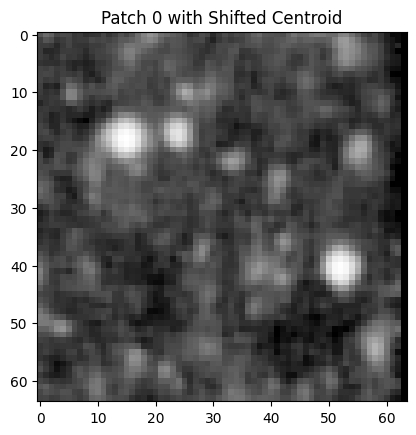

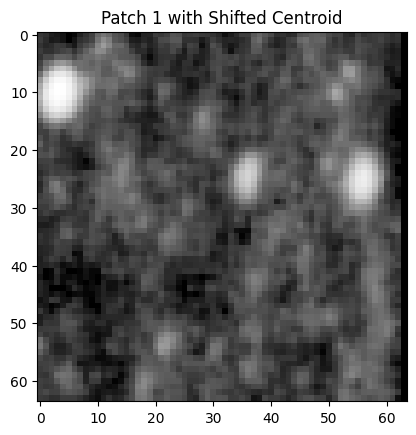

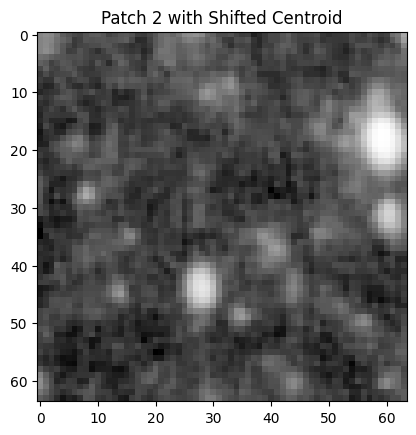

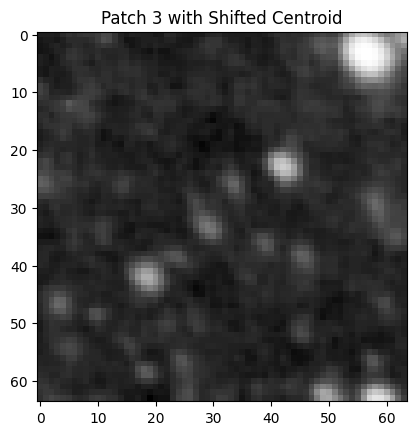

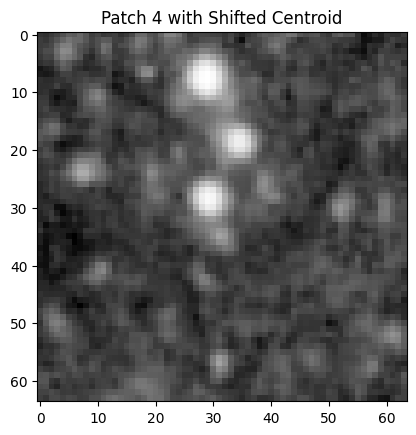

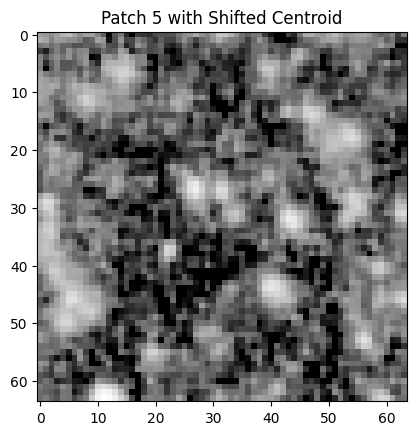

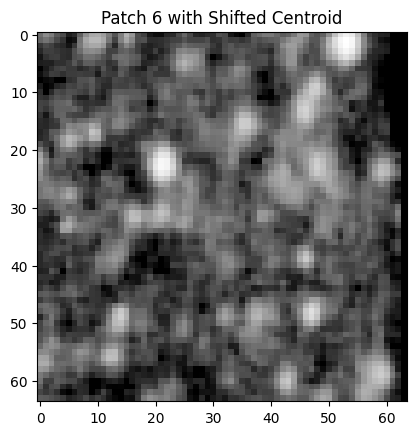

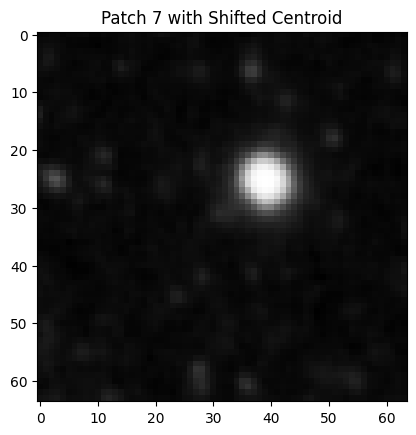

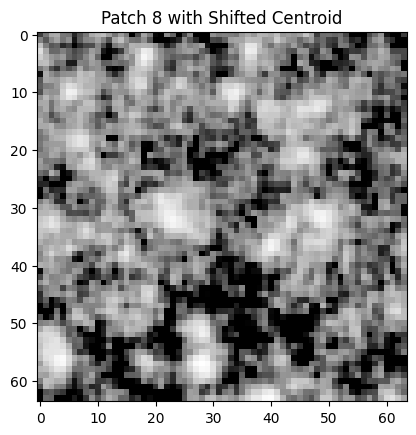

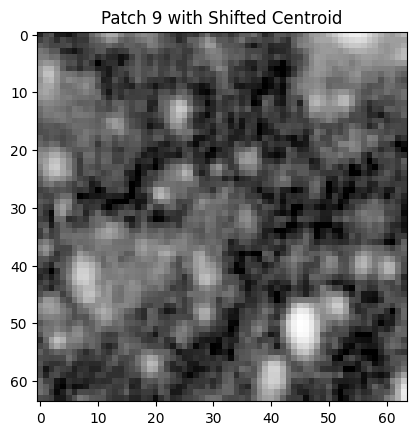

In [28]:
def safe_centroid(x, y, image, size=64):
    half = size // 2
    x = max(half, min(image.shape[0] - half, x))
    y = max(half, min(image.shape[1] - half, y))
    return x, y

def rgb_to_grayscale(patch):
    if patch.ndim == 3:
        return np.dot(patch[...,:3], [0.2989, 0.5870, 0.1140])
    else:
        return patch

for i in range(10):  # Loop over first 10 catalog entries
    x = catalog['xcentroid'].iloc[i]
    y = catalog['ycentroid'].iloc[i]
    x_safe, y_safe = safe_centroid(x, y, rgb_data)

    patch = make_patchs(rgb_data, x_safe, y_safe)
    gray_patch = rgb_to_grayscale(patch) # Makes the patch grayscale

    plt.imshow(apply_stretch(gray_patch), cmap='gray')
    plt.title(f"Patch {i} with Shifted Centroid")
    plt.show()


## Task 4: Build a CNN (8 points)
- Use TensorFlow/Keras to build a small CNN.
    - Recommended architecture:
    - Conv2D → ReLU → MaxPool
    - Conv2D → ReLU → MaxPool
    - Flatten → Dense → Softmax

You can adapt this depending on whether you are doing binary or multi-class classification.

In [20]:
from re import M
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = 4

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras import Model

num_classes = 4

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))



model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
catalog['spectral_type'].unique()

array([nan, '', 'A2'], dtype=object)

## Task 5: Train the Model (10 points)

Now use the top 100 (you can also use more to generate better training data) objects with all information in your image to train your model on the parameters spectral class and absolute magnitude and distance if possible. If you do not have all types genererate 10 examples of each type missing.
Store the resulting pandas dataframe as `catalog.csv` in the same directory as you Jupyter notebook.

Split your dataset into training, validation, and test sets.
- Use categorical crossentropy loss and an appropriate optimizer (e.g., Adam).
- Plot training and validation accuracy/loss curves.

Hint: SIMBAD has a very detailed set of spectral types. Group them according to the main letter (O, B, A, F, G, K, M)

Ask a LLM what final plot you should generate that shows if the CNN works for classification. Generate that plot.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np



def extral_spectral_class(s):
  """simplify spectral classes e.g. M1 --> M"""
  if isinstance(s, str) and len(s) > 0:
    return s[0]
  else:
    return np.nan

catalog['simple_spectral_class'] = catalog['spectral_type'].apply(extral_spectral_class)
catalog.head(100)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,star_name,spectral_type,object_type,visual_mag,simple_spectral_class,spectral_label
849,850,762.617670,1698.285320,0.393441,0.508725,0.280985,25,55592.666667,863933.333333,-14.841201,-6.306582,97.525854,9.032401,NaN,NaN,NaN,NaN,NaN,1
935,936,270.189192,1883.728999,0.467650,0.253469,0.292611,25,44927.666667,631321.333333,-14.500626,-6.174538,98.069253,8.818266,NaN,NaN,NaN,NaN,NaN,1
162,163,172.323143,665.960800,0.382743,0.672629,-0.054889,25,32595.333333,431033.333333,-14.086277,-6.042414,98.194478,10.165492,NaN,NaN,NaN,NaN,NaN,1
32,33,868.502864,224.172201,0.413062,0.097708,0.531266,25,24428.333333,366451.000000,-13.910040,-5.474822,97.428705,10.667192,NaN,NaN,NaN,NaN,NaN,1
284,285,536.656013,874.877922,0.428316,0.229937,-0.122278,25,31826.333333,354293.333333,-13.873407,-6.141146,97.787681,9.940515,TYC 737-331-2,,*,10.15,NaN,1
82,83,209.456015,434.268718,0.414549,0.915600,0.281041,25,23477.000000,302093.333333,-13.700353,-5.729350,98.156492,10.422801,NaN,NaN,NaN,NaN,NaN,1
747,748,447.772022,1525.379333,0.464987,0.415208,0.208688,25,24964.666667,296273.666667,-13.679233,-5.760270,97.877291,9.218363,HD 46077,A2,SB*,8.06,A,0
184,185,713.002122,706.316598,0.388444,0.341650,0.115665,25,25095.000000,286229.000000,-13.641784,-5.934751,97.594484,10.130355,HD 45867,A2,*,8.23,A,0
101,102,112.769993,524.008081,0.476320,0.684132,-0.022722,25,12361.666667,157525.333333,-12.993376,-4.941257,98.262453,10.321683,NaN,NaN,NaN,NaN,NaN,1
261,262,265.723346,846.111656,0.500155,0.353885,-0.159704,25,14880.666667,151282.666667,-12.949473,-5.305962,98.088453,9.967586,NaN,NaN,NaN,NaN,NaN,1


In [24]:
le = LabelEncoder()
catalog['spectral_label'] = le.fit_transform(catalog['simple_spectral_class'])
catalog.head(100)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,star_name,spectral_type,object_type,visual_mag,simple_spectral_class,spectral_label
849,850,762.617670,1698.285320,0.393441,0.508725,0.280985,25,55592.666667,863933.333333,-14.841201,-6.306582,97.525854,9.032401,NaN,NaN,NaN,NaN,NaN,1
935,936,270.189192,1883.728999,0.467650,0.253469,0.292611,25,44927.666667,631321.333333,-14.500626,-6.174538,98.069253,8.818266,NaN,NaN,NaN,NaN,NaN,1
162,163,172.323143,665.960800,0.382743,0.672629,-0.054889,25,32595.333333,431033.333333,-14.086277,-6.042414,98.194478,10.165492,NaN,NaN,NaN,NaN,NaN,1
32,33,868.502864,224.172201,0.413062,0.097708,0.531266,25,24428.333333,366451.000000,-13.910040,-5.474822,97.428705,10.667192,NaN,NaN,NaN,NaN,NaN,1
284,285,536.656013,874.877922,0.428316,0.229937,-0.122278,25,31826.333333,354293.333333,-13.873407,-6.141146,97.787681,9.940515,TYC 737-331-2,,*,10.15,NaN,1
82,83,209.456015,434.268718,0.414549,0.915600,0.281041,25,23477.000000,302093.333333,-13.700353,-5.729350,98.156492,10.422801,NaN,NaN,NaN,NaN,NaN,1
747,748,447.772022,1525.379333,0.464987,0.415208,0.208688,25,24964.666667,296273.666667,-13.679233,-5.760270,97.877291,9.218363,HD 46077,A2,SB*,8.06,A,0
184,185,713.002122,706.316598,0.388444,0.341650,0.115665,25,25095.000000,286229.000000,-13.641784,-5.934751,97.594484,10.130355,HD 45867,A2,*,8.23,A,0
101,102,112.769993,524.008081,0.476320,0.684132,-0.022722,25,12361.666667,157525.333333,-12.993376,-4.941257,98.262453,10.321683,NaN,NaN,NaN,NaN,NaN,1
261,262,265.723346,846.111656,0.500155,0.353885,-0.159704,25,14880.666667,151282.666667,-12.949473,-5.305962,98.088453,9.967586,NaN,NaN,NaN,NaN,NaN,1


In [35]:
catalog.to_csv('catalog.csv')

In [30]:
def make_patch(image, x, y, size=64):
    half = size / 2
    x_min = int(np.clip(x - half, 0, image.shape[0] - 1))
    x_max = int(np.clip(x + half, 1, image.shape[0]))  # ensure at least 1 pixel
    y_min = int(np.clip(y - half, 0, image.shape[1] - 1))
    y_max = int(np.clip(y + half, 1, image.shape[1]))  # ensure at least 1 pixel

    patch = image[x_min:x_max, y_min:y_max]

    # Pad the patch if it's smaller than the desired size
    pad_x = size - patch.shape[0]
    pad_y = size - patch.shape[1]
    if pad_x > 0 or pad_y > 0:
        patch = np.pad(patch, ((0, pad_x), (0, pad_y), (0, 0)), 'constant')
    return patch

In [31]:
patches = []
for _, row in catalog.iterrows():
  patch = make_patch(rgb_data, row['xcentroid'], row['ycentroid'])
  # Ensure all patches have the same shape by resizing or padding
  patch = patch[:64, :64, :]  # Adjust if your desired shape is different
  # Pad if patch is smaller than 64x64
  if patch.shape[0] < 64 or patch.shape[1] < 64:
    pad_height = 64 - patch.shape[0]
    pad_width = 64 - patch.shape[1]
    patch = np.pad(patch, ((0, pad_height), (0, pad_width), (0, 0)), 'constant')
  patches.append(patch)

x = np.array(patches)[..., np.newaxis]
y = catalog['spectral_label'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 89.4938 - val_accuracy: 0.0000e+00 - val_loss: 468.8109
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2500 - loss: 661.6498 - val_accuracy: 0.5000 - val_loss: 2.9821
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8750 - loss: 0.6121 - val_accuracy: 0.5000 - val_loss: 0.4502
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.1243 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8750 - loss: 0.4487 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8750 - loss: 0.6037 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8750 - loss: 0.5626 - val_accuracy: 1.0000 - val_loss: 0.0096
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8750 - loss: 0.4242 - val_accuracy: 1.0000 - val

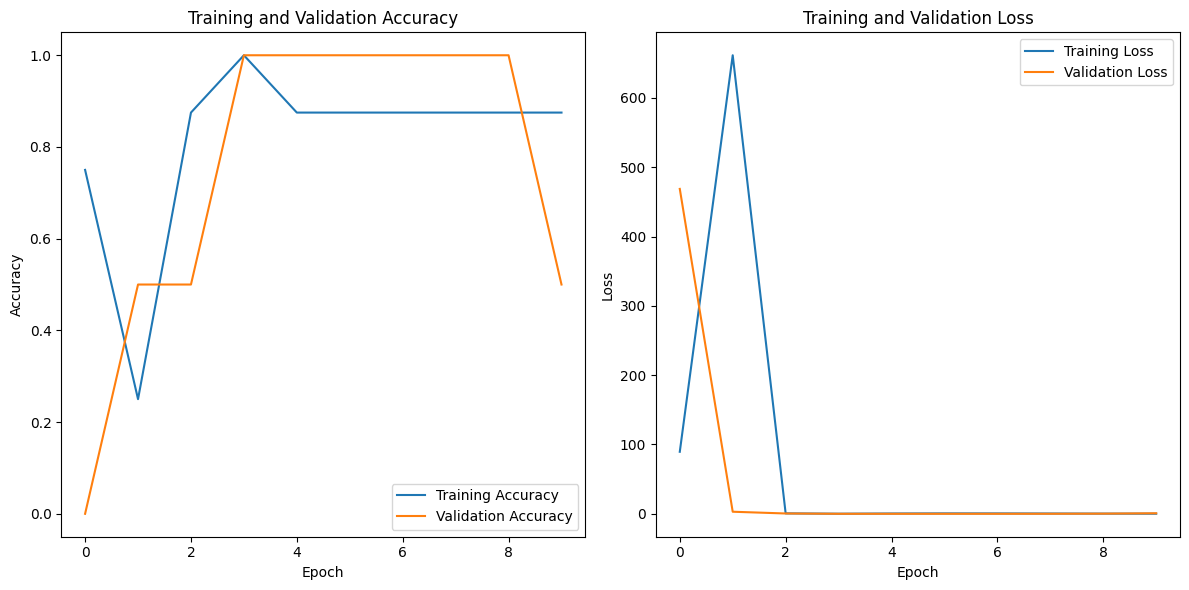

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')  # Number of classes (spectral labels)
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()